In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from math import sqrt
#to ignore the warnings
import warnings
warnings.filterwarnings('ignore')


## Reading the data. Explicitly mentioned to read the date column in data as date.  Make date column as index

In [54]:
df_raw = pd.read_csv("..\Resources\Prod_Forecast.csv",parse_dates=['Date'], index_col='Date', dayfirst=True)
df_raw.head()

,Well,Well_Type,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,,,
2015-01-10,Well 10,Pre-perf,192.00,51.00,38.00,63.00,235.00,2.00
2015-01-11,Well 10,Pre-perf,308.00,43.00,31.00,67.00,235.00,37.00
2015-01-12,Well 10,Pre-perf,308.00,41.00,31.00,67.00,239.00,59.00
2015-01-13,Well 10,Pre-perf,309.09,40.53,29.90,67.04,238.86,59.69
2015-01-14,Well 10,Pre-perf,308.18,40.46,29.84,67.06,236.16,56.57


## Check if there is null/NaN data

In [55]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10014 entries, 2015-01-10 to 2018-08-04
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Well                10014 non-null  object 
 1   Well_Type           10014 non-null  object 
 2   WaterRate           10014 non-null  float64
 3   CasingHeadPressure  10014 non-null  float64
 4   TubingHeadPressure  10014 non-null  float64
 5   PumpSpeed           10014 non-null  float64
 6   Torque              10014 non-null  float64
 7   GasRate             10014 non-null  float64
dtypes: float64(6), object(2)
memory usage: 704.1+ KB


In [56]:
df_raw.describe()

,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
count,10014.000000,10014.000000,10014.000000,10014.000000,10014.000000,10014.000000
mean,255.401030,58.345532,57.180661,143.820432,246.935557,446.143849
std,186.126892,35.609559,20.591074,62.513463,115.562883,400.881072
min,0.000000,23.000000,0.040000,0.000000,0.010000,0.000000
25%,118.280000,42.060000,42.500000,100.000000,154.335000,171.482500
50%,221.490000,51.050000,53.850000,135.000000,242.660000,337.430000
75%,366.010000,61.350000,70.477500,188.000000,314.000000,548.610000
max,1184.130000,397.000000,387.000000,343.000000,753.000000,1867.940000


In [57]:
wellnames = df_raw.Well.unique()
wellnames

array(['Well 10', 'Well 11', 'Well 12', 'Well 13', 'Well 15', 'Well 14',
       'Well 1', 'Well 2', 'Well 3', 'Well 4', 'Well 5', 'Well 6',
       'Well 7', 'Well 8', 'Well 9'], dtype=object)

## Check if we have null/NaN

In [58]:
df_raw.isnull().sum()

Well                  0
Well_Type             0
WaterRate             0
CasingHeadPressure    0
TubingHeadPressure    0
PumpSpeed             0
Torque                0
GasRate               0
dtype: int64

## Count the Number of rows per well

In [59]:
wellcount = df_raw.Well.value_counts()
wellcount

Well 1     1359
Well 7     1230
Well 15    1220
Well 9     1199
Well 10    1078
Well 8     1052
Well 14     605
Well 12     384
Well 13     372
Well 6      358
Well 3      277
Well 2      277
Well 4      274
Well 5      168
Well 11     161
Name: Well, dtype: int64

In [60]:
df_welltype = df_raw.Well_Type

In [61]:
# sort the data based on the Well and Date
df = df_raw.sort_values(['Well', 'Date'])
df

,Well,Well_Type,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,,,
2014-12-22,Well 1,Pre-perf,3.00,51.00,18.00,1.00,1.00,6.00
2014-12-23,Well 1,Pre-perf,90.00,29.00,29.00,88.00,186.00,0.00
2014-12-24,Well 1,Pre-perf,100.00,29.00,30.00,98.00,191.00,0.00
2014-12-25,Well 1,Pre-perf,102.89,29.12,29.68,97.77,167.97,0.00
2014-12-26,Well 1,Pre-perf,104.00,29.00,30.00,98.00,156.00,0.00
...,...,...,...,...,...,...,...,...
2018-07-31,Well 9,Pre-perf,26.44,49.89,51.32,165.00,138.66,160.32
2018-08-01,Well 9,Pre-perf,42.88,50.33,50.93,159.00,254.46,169.09
2018-08-02,Well 9,Pre-perf,42.88,49.89,51.41,163.00,260.36,155.60


## For this exercise Well 1 will be used for Forecasting

In [62]:
Well_Forecast = df_raw[(df_raw['Well'] == 'Well 1')]
Well_Forecast

,Well,Well_Type,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,,,
2014-12-22,Well 1,Pre-perf,3.00,51.00,18.00,1.00,1.00,6.00
2014-12-23,Well 1,Pre-perf,90.00,29.00,29.00,88.00,186.00,0.00
2014-12-24,Well 1,Pre-perf,100.00,29.00,30.00,98.00,191.00,0.00
2014-12-25,Well 1,Pre-perf,102.89,29.12,29.68,97.77,167.97,0.00
2014-12-26,Well 1,Pre-perf,104.00,29.00,30.00,98.00,156.00,0.00
...,...,...,...,...,...,...,...,...
2018-12-27,Well 1,Pre-perf,33.48,48.73,48.49,134.00,116.53,134.93
2018-12-28,Well 1,Pre-perf,33.73,50.33,50.38,134.00,116.53,134.75
2018-12-29,Well 1,Pre-perf,33.64,50.33,50.84,134.00,115.80,134.00


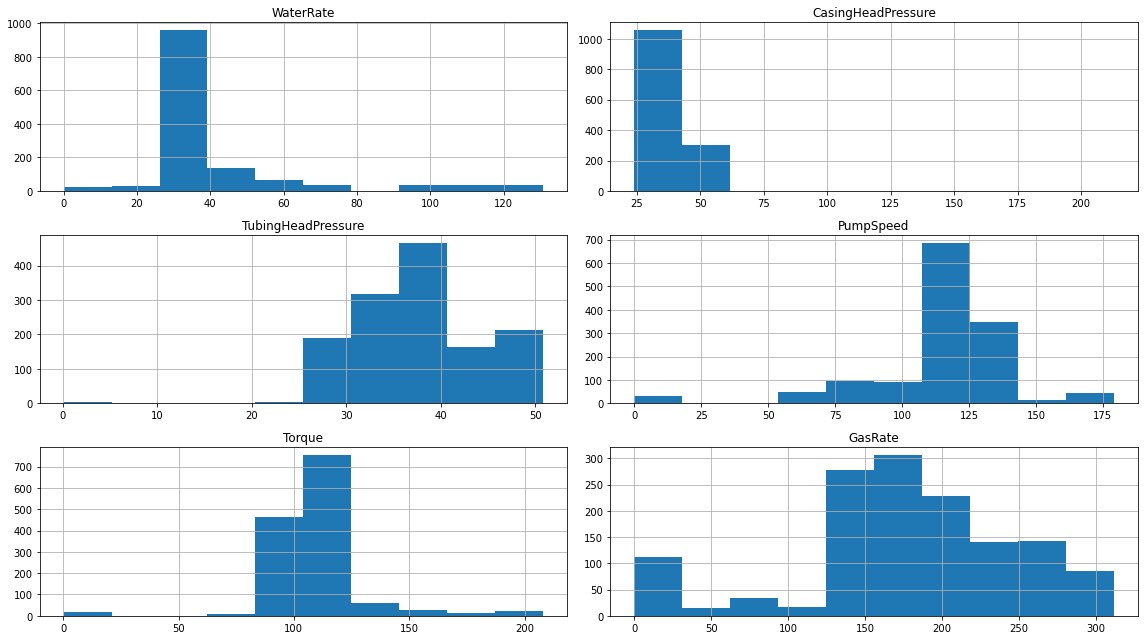

In [63]:
Well_Forecast.hist(figsize = (16,9))
plt.tight_layout()
plt.show()

### Seem the target data (Gas Rate is not Gaussian, i.e. Stationary). Lets do another test using Coint Johansen

In [64]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
Welldata = Well_Forecast.drop(['Well', 'Well_Type'], axis=1)
coint_johansen(Welldata,-1,1).eig

array([1.69632862e-01, 5.46762882e-02, 3.40432085e-02, 1.24703653e-02,
       4.29493337e-03, 7.38609404e-05])

In [65]:
Welldata.head()

,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,
2014-12-22,3.00,51.00,18.00,1.00,1.00,6.0
2014-12-23,90.00,29.00,29.00,88.00,186.00,0.0
2014-12-24,100.00,29.00,30.00,98.00,191.00,0.0
2014-12-25,102.89,29.12,29.68,97.77,167.97,0.0
2014-12-26,104.00,29.00,30.00,98.00,156.00,0.0


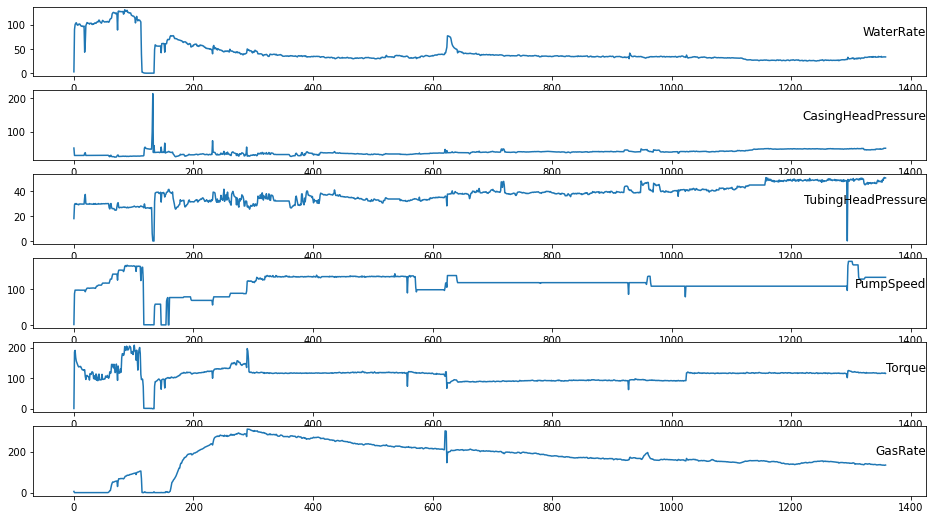

In [66]:
values = Welldata.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure(figsize=(16,9))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(Welldata.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

## We will frame the supervised learning problem as predicting the GasRate at the current day (t) given the features measurements at the previous day. To do this we will need to shift the dataset by (1), and add the GasRate observation to the new dataframe

In [67]:
cols = Welldata.columns
# reframed_df={}
reframed_df = Welldata.shift(1)
# reframed_df = reframed_df.rename(columns={'GasRate': 'Output'})
# reframed_df.insert(5, 'Output', Welldata['GasRate'])
reframed_df['Output'] = Welldata['GasRate']
reframed_df.head()

,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate,Output
Date,,,,,,,
2014-12-22,NaN,NaN,NaN,NaN,NaN,NaN,6.0
2014-12-23,3.00,51.00,18.00,1.00,1.00,6.0,0.0
2014-12-24,90.00,29.00,29.00,88.00,186.00,0.0,0.0
2014-12-25,100.00,29.00,30.00,98.00,191.00,0.0,0.0
2014-12-26,102.89,29.12,29.68,97.77,167.97,0.0,0.0


In [68]:
reframed_df.isnull().sum()

WaterRate             1
CasingHeadPressure    1
TubingHeadPressure    1
PumpSpeed             1
Torque                1
GasRate               1
Output                0
dtype: int64

In [69]:
reframed_df.dropna(inplace = True)
reframed_df

,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate,Output
Date,,,,,,,
2014-12-23,3.00,51.00,18.00,1.00,1.00,6.00,0.00
2014-12-24,90.00,29.00,29.00,88.00,186.00,0.00,0.00
2014-12-25,100.00,29.00,30.00,98.00,191.00,0.00,0.00
2014-12-26,102.89,29.12,29.68,97.77,167.97,0.00,0.00
2014-12-27,104.00,29.00,30.00,98.00,156.00,0.00,0.00
...,...,...,...,...,...,...,...
2018-12-27,33.47,48.15,49.30,134.00,116.53,134.78,134.93
2018-12-28,33.48,48.73,48.49,134.00,116.53,134.93,134.75
2018-12-29,33.73,50.33,50.38,134.00,116.53,134.75,134.00


## Split datasets into input (X) and output (y)

In [121]:
X = reframed_df.iloc[:,:-1]
y = reframed_df.iloc[:,-1]
y.shape
X.shape

(1358, 6)

## Split dataset into train and test sets
### We will use data before 2018 as the train datatsets and the remaining as test datasets

In [71]:
#creating the train and validation set
X_train = X.iloc[:993,]
y_train = y.iloc[:993,]
X_test = X.iloc[993:,]
y_test = y.iloc[993:,]


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(993, 6) (993,) (365, 6) (365,)


## Normalize the data using standard scalar. 

In [72]:
from sklearn import preprocessing

Scaled = preprocessing.StandardScaler()
X_train_scaled = Scaled.fit_transform(X_train)
X_test_scaled = Scaled.fit_transform(X_test)

## Define, train and predict using the MLP regressor model 

In [73]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import explained_variance_score

In [74]:
model = MLPRegressor(solver='adam', activation='relu', hidden_layer_sizes=(30, 80), random_state=42)

In [82]:
model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(30, 80), random_state=42)

In [83]:
y_pred = model.predict(X_test)

In [84]:
print ('Hidden layers = 30, 80')
print ('Explained_variance_score (r2 score) :', round(explained_variance_score(y_test,y_pred),2))
print ()
print ('Mean_squared_error (MSE) :', round(mean_squared_error(y_test,y_pred),3))
print ()
print ('Root Mean Square Error (RMSE):', round(sqrt(mean_squared_error(y_test,y_pred)),2))

Hidden layers = 30, 20
Explained_variance_score (r2 score) : 0.57

Mean_squared_error (MSE) : 25.321

Root Mean Square Error (RMSE): 5.03


<AxesSubplot:xlabel='Date'>

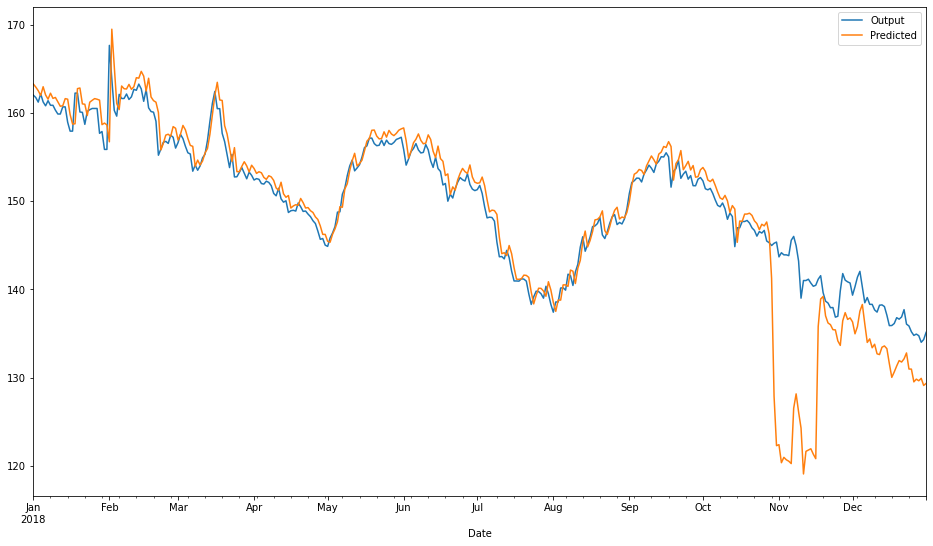

In [85]:
Output_df = pd.DataFrame(y_test)
Output_df['Predicted'] = y_pred
Output_df.plot(kind = 'line', figsize=(16,9))

## Test with other well

In [105]:
Wells = {}
for well in wellnames:
    Wells[f'{well}'] = df[df['Well'] == f'{well}']

In [107]:
well_no = ['Well 7', 'Well 8', 'Well 9', 'Well 10', 'Well 15']

In [123]:
shift_data = {}
X_dic, y_dic = {},{}
for well in well_no:
    shift_data[f'{well}'] = Wells[f'{well}'].shift(1)
    shift_data[f'{well}']['Actual'] = Wells[f'{well}']['GasRate']
    shift_data[f'{well}'].dropna(inplace = True)
    X_dic[f'{well}'] = shift_data[f'{well}'].iloc[:,2:-1]
    y_dic[f'{well}'] = shift_data[f'{well}'].iloc[:,-1]

X_dic['Well 7']

,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,
2014-12-18,353.00,372.00,387.00,100.00,270.00,0.00
2014-12-19,353.00,62.00,63.00,98.00,320.00,3.00
2014-12-20,352.94,61.76,63.39,97.67,320.30,3.43
2014-12-21,352.00,64.00,65.00,98.00,295.00,4.00
2014-12-22,359.00,66.00,67.00,98.00,283.00,2.00
...,...,...,...,...,...,...
2018-09-29,83.44,56.71,73.71,284.00,177.01,595.58
2018-09-30,69.56,56.13,71.86,284.00,178.49,552.03
2018-10-01,60.36,56.13,0.09,272.00,177.75,522.01


In [125]:
y_pred_dic = {}
for well in well_no:
    y_pred_dic[f'{well}'] = model.predict(X_dic[f'{well}'])
y_pred_dic['Well 7']

array([ 20.68071932,  53.06662263,  53.6215215 , ..., 506.19591647,
       394.39079078, 400.63498771])

## Create DataFrame for the results

In [128]:
Output_dic = {}
for well in well_no:
    Output_dic[f'{well}'] = pd.DataFrame(y_dic[f'{well}'])
    Output_dic[f'{well}']['Predicted'] = y_pred_dic[f'{well}']

<AxesSubplot:xlabel='Date'>

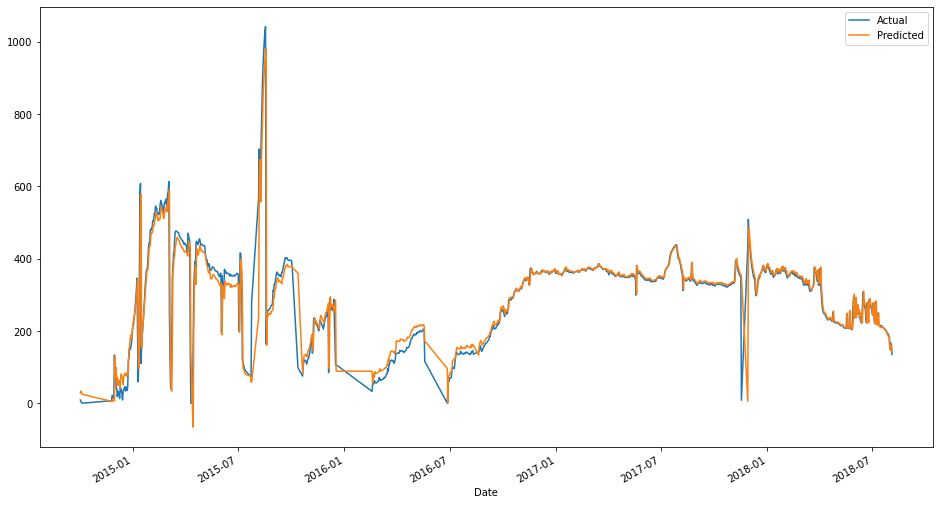

In [130]:

Output_df = pd.DataFrame(y_dic['Well 9'])
Output_df['Predicted'] = y_pred_dic['Well 9']
Output_df.plot(kind = 'line', figsize=(16,9))

In [ ]:
reframed_df = Welldata.shift(1)
# reframed_df = reframed_df.rename(columns={'GasRate': 'Output'})
# reframed_df.insert(5, 'Output', Welldata['GasRate'])
reframed_df['Output'] = Welldata['GasRate']
reframed_df.head()

In [108]:
Wells[f'{well_no[0]}']

,Well,Well_Type,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,,,
2014-12-17,Well 7,Pre-perf,353.00,372.00,387.00,100.00,270.00,0.00
2014-12-18,Well 7,Pre-perf,353.00,62.00,63.00,98.00,320.00,3.00
2014-12-19,Well 7,Pre-perf,352.94,61.76,63.39,97.67,320.30,3.43
2014-12-20,Well 7,Pre-perf,352.00,64.00,65.00,98.00,295.00,4.00
2014-12-21,Well 7,Pre-perf,359.00,66.00,67.00,98.00,283.00,2.00
...,...,...,...,...,...,...,...,...
2018-09-29,Well 7,Pre-perf,69.56,56.13,71.86,284.00,178.49,552.03
2018-09-30,Well 7,Pre-perf,60.36,56.13,0.09,272.00,177.75,522.01
2018-10-01,Well 7,Pre-perf,7.99,60.19,72.25,200.00,118.01,417.34


In [ ]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(t, s1, t, s2)
df1.plot(ax=axes[0])
df2.plot(ax=axes[1])


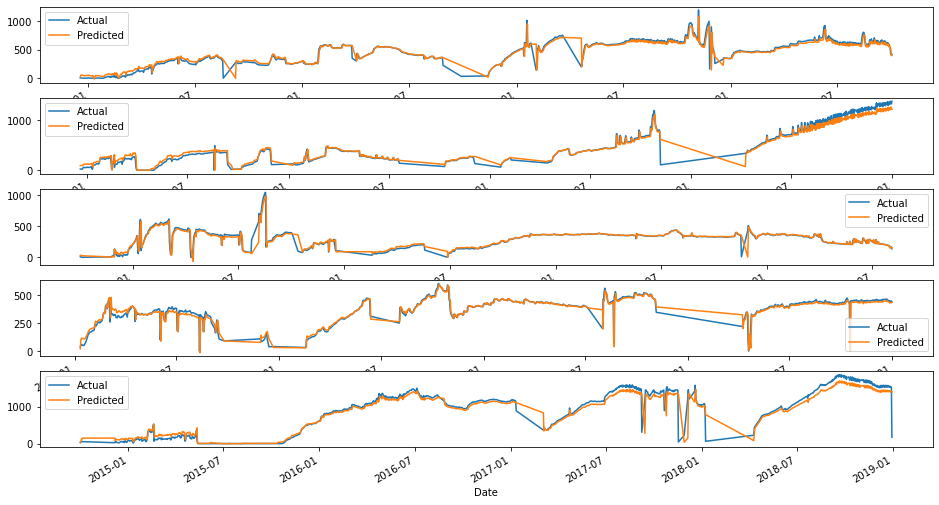

In [141]:
fig, axs = plt.subplots(len(well_no), 1, figsize=(16, 9), constrained_layout=False)
# fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(len(well_no)):
    Output_dic[f'{well_no[i]}'].plot(kind = 'line', ax = axs[i])
    
    # axs[i].set_title(f'GasRate VS Time ({well_no[i]})')

In [ ]:
prediction

In [ ]:
well_1

In [ ]:
ind_pred = valid.index

In [ ]:
df_pred = pd.DataFrame(data=prediction, index=ind_pred, columns=cols)


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
#converting predictions to dataframe
cols = well_1.columns
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,6):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

In [ ]:
#make final predictions
model = VAR(endog=well_1)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

In [ ]:
df_blind.insert(5, 'Predicted_gas_rate', y_pred_blind)

### The mean and variance look similar, suggesting that stationary dataset. Additionally we can perform `Dickey-Fuller` test 

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['GasRate'])

print (f"ADF =  {str(adf_test[0])}")
print (f"p-value = {str(adf_test[1])}")

### as the p-value is less than 0.05, we can reject null hypotesis (non-stationary data) and can assume our data is stationary.

In [ ]:
# Store all wells data in dictionary for plotting purpose
Wells={}
for well in wellnames:
    Wells[f'{well}']=df[df['Well'] == well ]

In [ ]:
Wells['Well 1']['GasRate']

In [ ]:
j = 0
i = 0
fig, axs = plt.subplots(5, 3, figsize=(32,18))
for well in wellnames:
    if j == 3:
        i+=1
        j=0
    Wells[well]['GasRate'].plot(kind='line', ax = axs[i,j], title = well, fontsize=16)
    j+=1
fig.suptitle('Gas Rate overtime for Each Wells', fontsize=32)
fig.tight_layout(pad=3.0)
plt.show()

In [ ]:
df['GasRate'].plot(kind='line', figsize = (32,18))
plt.title('Gas Rate from overall wells', fontsize=20)

### From the Gas Rate plots above, seems that the wells have different type of timeseries. The well timeseries types are as follows:
- trend (well no. 11, 12, 2, 3, 4, 1)
- seasonal (well no. 5, 6, 14)
- stationary (well no. 10, 7, 8, 9, 13, 15) 

### Now, lets find the correlation between various features with Gas Rate  

In [ ]:
import seaborn as sns
corr = df.corr()
ax, fig = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=-1, cmap='coolwarm', annot=True)
plt.show()

### It can be seen that the Pumpspeed, Water Rate, Torque, Tubing Head pressure and Casing Head Pressure has the strongest correlation to Gas Rate, in that order. Sinxe Casing HeadPressure has least correlation (3.4%), for this exercise this feature will not be use in forecasting

# Preprocess the datasets

### Drop the unused features, CasingHeadPressure and Well_Type

In [ ]:
df = df.drop(columns=['Well_Type', 'CasingHeadPressure'])
df.head()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16,9))
lags = [1, 3, 5, 9]
j = 0
i = 0
for k in range(4):
    if j == 2:
        i+=1
        j=0
    pd.plotting.lag_plot(df['GasRate'], lag = lags[k], ax = axs[i,j])
    j+=1

In [ ]:
pd.plotting.autocorrelation_plot(df['GasRate'])


### As seen from the autocorrelation plots, the t = 1 has the most correlation. Lets test the correlation for first few lag t

In [ ]:
lags = [1,3,5]
for lag in lags:
    cor = df['GasRate'].corr(df['GasRate'].shift(lag))
    print (f'corr-value = {cor}, for lag = {lag}')

### For a start lets do with lag = 1

In [ ]:
for well in wellnames:
    df['GasRate'][df['Well']==well]=df['GasRate'][df['Well']==well].shift(-1)

In [ ]:
df.isnull().sum()

In [ ]:
df=df.dropna()

In [ ]:
df.isnull().sum()

In [ ]:
wellcount = df.Well.value_counts()
wellcount

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposed = seasonal_decompose(df['GasRate'], model='additive')
# x = decomposed.plot() #See note below about this

## Split the Dataset

In [ ]:
df_train = df[(df['Well'] == 'Well 2')]

In [ ]:
print(df_train.Well.unique())

In [ ]:
df_train.shape

In [ ]:
df_blind = df[(df['Well'] == 'Well 3')]


In [ ]:
df_blind.shape

In [ ]:
df_train.columns

In [ ]:
X = df_train.iloc[:,1:4]
y = df_train.iloc[:,5:6]

In [ ]:
X_blind = df_blind.iloc[:,1:4]
y_blind = df_blind.iloc[:,5:6]

## Normalize the data using standard scalar. 

In [ ]:
from sklearn import preprocessing

In [ ]:
Scaler = preprocessing.StandardScaler()

In [ ]:
X_scale = Scaler.fit_transform(X)
X_blind_scale = Scaler.transform(X_blind)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.25, random_state=42)

## Define, train and predict using the MLP regressor model 

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import explained_variance_score

In [ ]:
model = MLPRegressor(solver='adam', activation='relu', hidden_layer_sizes=(30, 20, 50), random_state=42)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print ('Hidden layers = 30, 20')
print ('Explained_variance_score (r2 score) :', round(explained_variance_score(y_test,y_pred),2))
print ()
print ('Mean_squared_error (MSE) :', round(mean_squared_error(y_test,y_pred),3))
print ()
print ('Root Mean Square Error (RMSE):', round(sqrt(mean_squared_error(y_test,y_pred)),2))

In [ ]:
y_pred_blind = model.predict(X_blind_scale)

In [ ]:
# Mean square error means average of a set of errors ( R2 score )
# print the expalined varaince and mean squared error values ( RMSE )
print ('Explained_variance_score (r2 score) :', round(explained_variance_score(y_blind,y_pred_blind),2))
print ()
print ('Mean_squared_error (MSE) :', round(mean_squared_error(y_blind,y_pred_blind),3))
print ()
print ('Root Mean Square Error (RMSE):', round(sqrt(mean_squared_error(y_blind,y_pred_blind)),2))

In [ ]:
df_blind.insert(5, 'Predicted_gas_rate', y_pred_blind)

In [ ]:
df_blind.head()

In [ ]:
df_blind = df_blind.sort_index()

In [ ]:
def plot_data(df,title=""):
    fig = plt.figure(figsize = (15,5))
#     plt.figure(figsize=(20,10), dpi=100)
    ax = fig.add_axes([0.1,0.1,1,1])
    ax.plot(df.index,df.GasRate,label='Actual GasRate')
    ax.plot(df.index,df.Predicted_gas_rate,label='Predicted_gas_rate')
    # ax.plot(x,z, c='green', alpha=0.5, marker='o', markersize = 10, label='Cosine') #alpha = transparency

    # ax.set_xlim(0,10)
    # ax.set_ylim(-1,1)

    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('GasRate')
    ax.set_title(title)

In [ ]:
plot_data(df_blind, 'GasRate VS Time (Well 12)' )

In [ ]:
from statsmodels.tsa.ar_model import AR

In [ ]:
#train the autoregression model
model = AR(X_train)
model_fitted = model.fit()